<a href="https://colab.research.google.com/github/Veronika2311/NNmethods_21/blob/main/hw2/cnn_6-Part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

понятное [видео](https://www.youtube.com/watch?v=bNb2fEVKeEo) со стенфордского курса, из [материалов](https://cs231n.github.io/convolutional-networks) по которому взяты иллюстрации.

Датасет из [курса](https://github.com/DanAnastasyev/DeepNLP-Course/blob/master/Week%2004/Week_04_Convolutional_Neural_Networks.ipynb) Даниила Анастасьева.

Использовались [материалы](https://github.com/mannefedov/hse_ml_m1/blob/master/7_cnn/cnn.ipynb) из курса Михаила Нефедова.

# Сверточный слой




Желтое - фильтр (= filter,kernel).

Зеленое - входные данные, например, изображение.

Розовое - карта активации (activation map).

Каждый элемент в розовой матрице - результат поэлементного умножения фильтра на числа из области на входных данных.
Обучаемые параметры - элементы фильтра.

![Conv](https://image.ibb.co/e6t8ZK/Convolution.gif)



Чтобы не терять размер матрицы используется паддинг.

![padding](https://3deep.ru/wp-content/uploads/2020/01/keras_conv2d_padding.gif)

from https://3deep.ru/machinelearning/

# Pooling слой  (не обучается)

![Pool](https://cs231n.github.io/assets/cnn/pool.jpeg)
![maxpool](https://cs231n.github.io/assets/cnn/maxpool.jpeg)

# Свертки для текстов устроены немного по-другому. В них на одну размерность меньше.

![text-convs](https://image.ibb.co/bC3Xun/2018_03_27_01_24_39.png)

From [Character-Aware Neural Language Models](https://arxiv.org/pdf/1508.06615.pdf)

# CNN для обработки текстов



In [ ]:
!pip install torchmetrics

     |████████████████████████████████| 332 kB 5.2 MB/s 


In [ ]:
!pip install ipdb

     |████████████████████████████████| 791 kB 6.0 MB/s 
     |████████████████████████████████| 374 kB 33.2 MB/s 
  Created wheel for ipdb: filename=ipdb-0.13.9-py3-none-any.whl size=11648 sha256=5ae4797ec8441a3848b0534452fec74c370911b2829f09bc2dd7bd4ba1f7260c
  Stored in directory: /root/.cache/pip/wheels/65/cd/cc/aaf92acae337a28fdd2aa4d632196a59745c8c39f76eaeed01
Successfully built ipdb
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Attempting uninstall: ipython
    Found existing installation: ipython 5.5.0
    Uninstalling ipython-5.5.0:
      Successfully uninstalled ipython-5.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 

In [ ]:
import pandas as pd
import numpy as np
from string import punctuation
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torchmetrics import F1
from torchmetrics.functional import f1, recall
import ipdb
from tqdm import tqdm

### Слова



### Скачивание и подготовка данных

Давайте не будем заново, мы их уже предобработали и в файл сохранили

In [ ]:
train_data =  pd.read_csv('train.csv', encoding='utf8')
val_data = pd.read_csv('val.csv')

In [ ]:
train_data[train_data.type == 1].shape[0] / train_data.shape[0]

0.5075193406116695

In [ ]:
train_data.head(50)

,Unnamed: 0,text,type,clean_texts
0,0,"эх, ехать на репу пора((\nЗавтра уже выступление.",0,"эх , ехать на репа пора ( ( завтра уже выступл..."
1,1,"Аллергия вышла,из-за этих тупых мандарин(((((((",0,"аллергия выйти , из - за этот тупой мандарин (..."
2,2,@KompaundTone550 @tatysho власть всегда была б...,1,"власть всегда была , просто теперь об знать ве..."
3,3,"@Alinockaa А хрен, я гулящая пока, потом насиж...",1,"а хрен , я пока , потом дома : dd но сегодня я..."
4,4,"RT @vik_vans: блин, слушала первый мини-альбом...",0,"rt @vik_vans : блин , слушать первый мини - ал..."
5,5,Как же не сделать фото на айфон в зеркале:-D h...,1,как же не сделать фото на айфон в
6,6,Заебись погулял... Мама пуховик постирала ;((,0,заебись погулял ... мама пуховик постирать ; ( (
7,7,#HappyBirthdayLouisfromCIS Почему я мало пиш...,0,# почему я мало писать в тви ; ( ( ( (
8,8,@cobyisnotalone ладно :(\nмне через полтора ча...,0,ладно :( мне через полтора час только
9,9,"@DashaSone вот да, это было бы идеально! Хочу ...",1,"вот да , это было бы идеальный ! хотеть все пр..."


Почему мы можем трогать только train_data? Потому что иначе может попасть что-нибудь из теста. Вероятно, будет не очень заментно, но исключать возможность не стоит, и на уровне слов она больше, чем на уровне символов

In [ ]:
vocab = Counter()
for text in tqdm(train_data['clean_texts']):
    vocab.update(str(text).split(' '))
print('всего уникальных слов:', len(vocab))

100%|██████████| 110648/110648 [00:00<00:00, 156407.38it/s]

всего уникальных слов: 18104


In [ ]:
vocab

Counter({'эх': 432,
         ',': 91586,
         'ехать': 716,
         'на': 18438,
         'репа': 15,
         'пора': 624,
         '(': 73730,
         'завтра': 2607,
         'уже': 5396,
         'выступление': 74,
         '.': 28976,
         'аллергия': 62,
         'выйти': 580,
         'из': 3394,
         '-': 16437,
         'за': 5858,
         'этот': 4816,
         'тупой': 258,
         'мандарин': 48,
         'власть': 73,
         'всегда': 1501,
         'была': 980,
         'просто': 3258,
         'теперь': 2679,
         'об': 399,
         'знать': 3277,
         'весь': 5747,
         'мир': 456,
         'они': 1756,
         'сами': 149,
         'себя': 2287,
         'имидж': 6,
         'сделать': 1478,
         ')': 71183,
         'а': 17063,
         'хрен': 132,
         'я': 31838,
         'пока': 1106,
         'потом': 1312,
         'дома': 868,
         ':': 24131,
         'dd': 611,
         'но': 7723,
         'сегодня': 4277,
        

In [ ]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 5:
        filtered_vocab.add(word)
    else:
        print(word) # мы всё в препроцессинге удалили
print('уникальных слов, встретившихся больше 5 раз:', len(filtered_vocab))

Выходные данные были обрезаны до нескольких последних строк (5000).
chrome
@narisha_narisha
ладонь
шалава
will
бодрячок
накопить
проживу
витать
поместиться
задротить
покраснеть
@vmeysters
частота
ребзя
берите
оправдаться
потанцевать
азазазаз
@leraaa__bln
too
91
тоскливый
арбуз
@belamova
странность
клаве
действенный
сыпать
шампунь
вручение
залипнуть
сапожки
предвкушать
обокрасть
@apocalypse1boom
@_k_m_v
две
@johnny_gigurda
круглосуточный
саппорт
командный
заклинание
спн
кузя
агааа
красочный
@inikitav
ода
олеська
ууух
манго
маленька
обзываться
обречь
непонимание
абстракция
@ian_my__love
дарите
@denkhmaa
@ishigshig
ваза
разбивать
склеить
обозвать
маяк
серёга
загрустить
@rinkanew
хэээй
@karinellalove1d
тащи
засмотреться
шантажировать
фаааак
робить
отчим
официант
заглючил
444
матушка
строение
европарламент
документация
засовывать
gt;:-/
добренький
насмеялись
простиии
прорубь
ёмаё
осложнение
beatles
врачиха
пашку
ip
@vestal_cr
ночьвластелинаколец
отдыхай
боиться
конешно
гарч
итс
окрылять
@un

In [ ]:
#создаем словарь с индексами symbol2id, для спецсимвола паддинга дефолтный индекс - 0
word2id = {'PAD':0}

for symbol in filtered_vocab:
    word2id[symbol] = len(word2id)

In [ ]:
#обратный словарь для того, чтобы раскодировать последовательность
id2word = {i:word for word, i in word2id.items()}

In [ ]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

In [ ]:
word2id[')'] # у нас есть скобочки, и это важно

8428

## Эмбеддинги

Фасттекст так фасттекст, давайте возьмём для него леммы

In [ ]:
from gensim.models import FastText

In [ ]:
fasttext_data = [str(i) for i in train_data['clean_texts'].tolist()]

In [ ]:
model_fasttext = FastText(fasttext_data, size=64, window=5, min_count=5)

In [ ]:
#model_fasttext.wv[')'] #есть скобочки в модели!

In [ ]:
model_embs = np.zeros((len(word2id), 64))
dict_of_non_wodel_embs = {} # логичнее для одинаковых слов использовать одинаковые эмбеддинги
len_non_model_words  = 0
# почему не случайные? потому что сейчас менять будем
for word, i in word2id.items():
    try:
        model_embs[i] = ft.wv[word]
    except:
        len_non_model_words += 1
        if word in dict_of_non_wodel_embs.keys():
            emb = dict_of_non_wodel_embs[word]
        else:
            emb = np.random.normal(0, 0.05, 64)
            dict_of_non_wodel_embs[word] = emb
        model_embs[i] = emb
print(len_non_model_words)

12508


### Dataset & DataLoader

In [ ]:
class TweetsDataset(Dataset):

    def __init__(self, dataset, word2id, DEVICE):
        self.dataset = [str(i) for i in dataset['clean_texts'].values]
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.target = dataset['type'].values
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        words = self.dataset[index].split(' ')
        ids = torch.LongTensor([self.word2id[word.lower()] for word in words if word.lower() in self.word2id])
        y = [self.target[index]]
        return ids, y

    def collate_fn(self, batch): #этот метод можно реализовывать и отдельно,
    # он понадобится для DataLoader во время итерации по батчам
        ids, y = list(zip(*batch))
        padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
        y = torch.Tensor(y).to(self.device)
        return padded_ids, y

### создаем итераторы по данным для трейна и теста

In [ ]:
train_dataset = TweetsDataset(train_data, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=64)

In [ ]:
batch = next(iter(train_iterator))

In [ ]:
batch[0].shape

torch.Size([64, 29])

In [ ]:
#[id2word[int(i)] for i in batch[0][0]]

In [ ]:
#batch[1]

In [ ]:
val_dataset = TweetsDataset(val_data, word2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=64)

In [ ]:
test_batch = next(iter(val_iterator))
test_batch[0].shape

torch.Size([64, 34])

### CNN model

In [ ]:
fm = torch.randn(3, 8, 4) #batch_size, num_filters, seq_len
fm

tensor([[[ 2.2132, -0.6009, -0.5998,  0.2961],
         [ 0.1465,  0.0903,  1.0241, -0.1701],
         [ 2.1096,  0.3265, -0.2067, -0.2377],
         [ 0.7234, -1.7027, -1.7829, -0.5288],
         [ 0.8054, -0.2665, -0.2316, -0.4426],
         [-0.2428,  0.4116, -0.7853, -0.9172],
         [ 2.3757,  0.5534, -0.0397, -0.1202],
         [-0.2006,  0.9518,  0.0825, -1.6293]],

        [[-2.4963,  0.3021, -0.6923, -0.1405],
         [ 0.1725,  0.1652,  0.1494,  2.1479],
         [-0.2048, -0.9394,  0.4774, -0.1827],
         [ 0.3127, -0.5725, -1.0951,  0.2467],
         [ 0.2797, -1.2602,  1.4755, -0.7090],
         [ 0.1282,  0.0581, -2.0635,  2.1928],
         [ 0.6058,  0.7187,  1.5670, -0.2594],
         [-1.9331,  0.3306, -0.4899,  0.9079]],

        [[-0.8942, -0.2567, -0.3846, -1.2000],
         [ 0.1187, -0.1186, -0.8709,  1.9581],
         [ 1.7259,  0.0811, -0.5189, -0.2884],
         [ 0.0771,  1.8567,  0.0337,  0.3826],
         [ 0.1752,  0.3068,  0.8320,  1.9100],
         

In [ ]:
mp = torch.nn.MaxPool1d(kernel_size=2, stride=2)
print(mp(fm).shape)
mp(fm)

torch.Size([3, 8, 2])


tensor([[[ 2.2132,  0.2961],
         [ 0.1465,  1.0241],
         [ 2.1096, -0.2067],
         [ 0.7234, -0.5288],
         [ 0.8054, -0.2316],
         [ 0.4116, -0.7853],
         [ 2.3757, -0.0397],
         [ 0.9518,  0.0825]],

        [[ 0.3021, -0.1405],
         [ 0.1725,  2.1479],
         [-0.2048,  0.4774],
         [ 0.3127,  0.2467],
         [ 0.2797,  1.4755],
         [ 0.1282,  2.1928],
         [ 0.7187,  1.5670],
         [ 0.3306,  0.9079]],

        [[-0.2567, -0.3846],
         [ 0.1187,  1.9581],
         [ 1.7259, -0.2884],
         [ 1.8567,  0.3826],
         [ 0.3068,  1.9100],
         [ 0.0841,  0.3739],
         [ 1.6376,  0.4661],
         [ 0.5925, -0.0432]]])

In [ ]:
fm.max(2)[0]

tensor([[ 2.2132,  1.0241,  2.1096,  0.7234,  0.8054,  0.4116,  2.3757,  0.9518],
        [ 0.3021,  2.1479,  0.4774,  0.3127,  1.4755,  2.1928,  1.5670,  0.9079],
        [-0.2567,  1.9581,  1.7259,  1.8567,  1.9100,  0.3739,  1.6376,  0.5925]])

In [ ]:
class CNN(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, model_embs):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.from_pretrained(torch.tensor(model_embs), freeze=True)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.concat_bigrams = nn.Conv1d(in_channels=180, out_channels=100, kernel_size=2, padding='same')
        #self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=100, out_features=1)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()

    def forward(self, text):
        #batch_size x seq_len
        embedded = self.embedding(text)
        #batch_size x seq_len x embedding_dim
        embedded = embedded.transpose(1,2)
        #batch_size x embedding_dim x seq_len
        #feature_map_bigrams = self.dropout(self.pooling(self.relu(self.bigrams(embedded))))
        #batch_size x filter_count2 x seq_len* 
        #feature_map_trigrams = self.dropout(self.pooling(self.relu(self.trigrams(embedded))))
        #batch_size x filter_count3 x seq_len*
        feature_map_bigrams = self.relu(self.bigrams(embedded))
        # batch_size x filter_count3 x seq_len*
        feature_map_trigrams = self.relu(self.trigrams(embedded))

        #pooling1 = feature_map_bigrams.max(2)[0] 
        # batch_size x filter_count2
        #pooling2 = feature_map_trigrams.max(2)[0]
        # batch_size x filter_count3
        concat = torch.cat((feature_map_bigrams, feature_map_trigrams), 1)
        
        feature_map_concat = self.relu(self.concat_bigrams(concat))
        pooling = feature_map_concat.max(2)[0]
        # batch _size x (filter_count2 + filter_count3)
        logits = self.hidden(pooling)
        logits = self.out(logits)
        
        return logits

In [ ]:
batch, y = next(iter(train_iterator))
batch, y = batch.to(device='cpu'), y.to(device='cpu')
print(batch)

tensor([[ 9693,  9952,   838,  ...,     0,     0,     0],
        [11949,  9215, 10388,  ...,     0,     0,     0],
        [ 5074,  3434, 11426,  ...,     0,     0,     0],
        ...,
        [ 4320, 11992,    41,  ...,     0,     0,     0],
        [ 5432,  6531,  1320,  ...,     0,     0,     0],
        [ 4864,  8384,  4780,  ...,     0,     0,     0]])


In [ ]:
print(batch)

tensor([[ 9693,  9952,   838,  ...,     0,     0,     0],
        [11949,  9215, 10388,  ...,     0,     0,     0],
        [ 5074,  3434, 11426,  ...,     0,     0,     0],
        ...,
        [ 4320, 11992,    41,  ...,     0,     0,     0],
        [ 5432,  6531,  1320,  ...,     0,     0,     0],
        [ 4864,  8384,  4780,  ...,     0,     0,     0]])


In [ ]:
y

tensor([[0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.]])

In [ ]:
model_embs.shape

(12508, 64)

In [ ]:
model = CNN(len(id2word), 64, model_embs)
output = model(batch)
print(output)

tensor([[0.4504],
        [0.4448],
        [0.4370],
        [0.4472],
        [0.4401],
        [0.4578],
        [0.4542],
        [0.4221],
        [0.4584],
        [0.4574],
        [0.4514],
        [0.4614],
        [0.4634],
        [0.4507],
        [0.4257],
        [0.4480],
        [0.4277],
        [0.4383],
        [0.4394],
        [0.4155],
        [0.4587],
        [0.4430],
        [0.4574],
        [0.4357],
        [0.4618],
        [0.4332],
        [0.4571],
        [0.4302],
        [0.4367],
        [0.4344],
        [0.4499],
        [0.4322],
        [0.4466],
        [0.4274],
        [0.4271],
        [0.4196],
        [0.4399],
        [0.4647],
        [0.4386],
        [0.4136],
        [0.4390],
        [0.4571],
        [0.4534],
        [0.4404],
        [0.4323],
        [0.4651],
        [0.4301],
        [0.4452],
        [0.4209],
        [0.4471],
        [0.4442],
        [0.4590],
        [0.4569],
        [0.4302],
        [0.4353],
        [0

In [ ]:
loss = nn.BCELoss()
loss(output, y)

tensor(0.7111, grad_fn=<BinaryCrossEntropyBackward0>)

In [ ]:
f1(output, y.long())

tensor(0.)

### training loop, логика обучения и валидации

теперь нам нужны функции для обучения и валидации,
каждый вызов функции - одна эпоха обучения 

За одну эпоху нам надо для каждого батча:

-- применить к нему модель, 

-- посчитать значение функции потерь, 

-- посчитать градиенты,

-- обновить веса (параметры модели)


In [ ]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0 # для подсчета среднего лосса на всех батчах

    model.train()  # ставим модель в обучение, явно указываем, что сейчас надо будет хранить градиенты у всех весов

    for i, (texts, ys) in enumerate(iterator): #итерируемся по батчам
        optimizer.zero_grad()  #обнуляем градиенты
        preds = model(texts)  #прогоняем данные через модель
        loss = criterion(preds, ys) #считаем значение функции потерь  
        loss.backward() #считаем градиенты  
        optimizer.step() #обновляем веса 
        epoch_loss += loss.item() #сохраняем значение функции потерь
        if not (i + 1) % int(len(iterator)/5):
            print(f'Train loss: {epoch_loss/i}')      
    return  epoch_loss / len(iterator) # возвращаем среднее значение лосса по всей выборке

In [ ]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            preds = model(texts)  # делаем предсказания на тесте
            loss = criterion(preds, ys)   # считаем значения функции ошибки для статистики  
            epoch_loss += loss.item()
            batch_metric = f1(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metric += batch_metric

            if not (i + 1) % int(len(iterator)/5):
                print(f'Val loss: {epoch_loss/i}, Val f1: {epoch_metric/i}')
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator) # возвращаем среднее значение по всей выборке

### инициализируем модель, задаем оптимизатор и функцию потерь

In [ ]:
model = CNN(len(word2id), 64, model_embs)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.BCELoss()

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

### запуск обучения!

In [ ]:
%%time
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(4):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)


starting Epoch 0
Training...
Train loss: 0.3228418038248323
Train loss: 0.2118012045384405
Train loss: 0.16518429247842564
Train loss: 0.13877135636575352
Train loss: 0.12190053143253303

Evaluating on train...
Val loss: 0.04834507851791026, Val f1: 0.9788408279418945
Val loss: 0.0473274984660576, Val f1: 0.9783356189727783
Val loss: 0.04779068145038996, Val f1: 0.9775931239128113
Val loss: 0.04774628795056649, Val f1: 0.9773163199424744
Val loss: 0.04762140378637429, Val f1: 0.9775029420852661

Evaluating on test...
Val loss: 0.04790796132551299, Val f1: 0.9838297367095947
Val loss: 0.04849208511817664, Val f1: 0.9791556000709534
Val loss: 0.049028554547999134, Val f1: 0.9777876734733582
Val loss: 0.04900492772950515, Val f1: 0.9770010113716125
Val loss: 0.04898738331437133, Val f1: 0.9768394827842712

starting Epoch 1
Training...
Train loss: 0.04712208720035093
Train loss: 0.0456833570735348
Train loss: 0.043917416413994666
Train loss: 0.04286968451207051
Train loss: 0.0418746812092

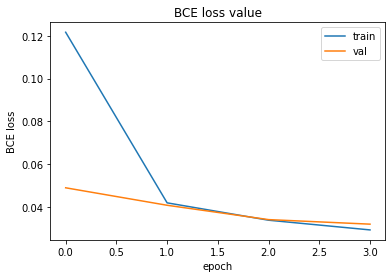

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

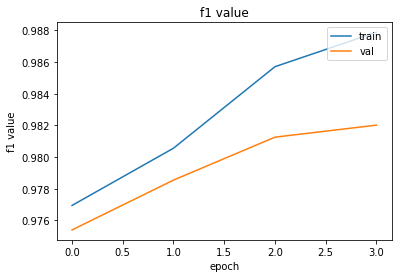

In [ ]:
import matplotlib.pyplot as plt
plt.plot([i.cpu() for i in f1s])
plt.plot([i.cpu() for i in f1s_eval])
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

Мы поменяли learning rate и добавили дропаут, кажется, стало лучше

Для анализа ошибок можно посмотреть на те примеры, которые мы (не)правильно предсказываем

In [ ]:
def predict(model, iterator):
    model.eval()
    fp = []
    fn = []
    tp = [] 
    tn = []
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            preds = model(texts)  # делаем предсказания на тесте 
            for pred, gold, text in zip(preds, ys, texts):
                text = ' '.join([id2word[int(word)] for word in text if word !=0])
                if round(pred.item()) > gold:
                    fp.append(text)
                elif round(pred.item()) < gold:
                    fn.append(text)
                elif round(pred.item()) == gold == 1:
                    tp.append(text)
                elif round(pred.item()) == gold == 0:
                    tn.append(text)
    return fp, fn, tp, tn

In [ ]:
fp, fn, tp, tn = predict(model, val_iterator)

И что это мы тут видим? Снова смайлики! И скобочки. И ярко позитивно/негативно окрашенные слова, хотя на них одиних модель справляется куда как хуже

In [ ]:
print('Верно позитивные:', tp[:10])

что правильно предсказываем: ['вот да , ибо мой творческий натура не на простор контакт в ) :d', 'q : посмотреть страница вк :) a :', 'бе шд тэ хэхэ :-))', 'весь поздравлять с день :)', '. :)', 'он смочь сделать это вечер . :-) # instantfollowback', 'была вчера в " " . там целый поляна - " рождественский звезда " . ! :)', 'когда он писать в твой тетрадка , когда ты это :*', 'энэ намайг дээр бсан юм бэ : )', 'мне всегда нравиться парень , которые старший меня :d я с ним иногда в вк переписываться , но в реал ни разу не разговаривать', 'в принцип дыа , но там нужный смотреть , в какой именно день , мочь уехать )', '# exo # ~ / / ! )', '@stpona -не очень . -ты как ? что так поздно ответить . :d', 'rt @bloody_saw82 : @tasteyogurt ахах ) и что же ты собираешься мне вырезать ?', 'главный , ни кто вместо меня в питер не владик разобраться как - нить :)))', 'перед обед был билет . я , решить после обед . когда вернуться , его уже купить ) ) ) теперь волос на себя )', 'вот еще один " вариант " 

In [ ]:
print('неверно негативные:', fn[:10])

неверно негативные: ['g красота самая главный неё нельзя !', 'и первый проблема , с которой я столкнуться , это выбор : , стоить ли the sims 4 так рано ?', 'rt @igorg1975 : и медаль после : t ”', 'rt : а мне очень _', 'rt : живой , здоровый ! ты нас очень напугать !', 'крутой варежка номер день !', 'rt : @egoyannarine я тоже тебя любить , * *', 'работа кать , кофта с высокий горло нет ?', 'rt : я долго ржать … & gt;:d', 'rt : @ocheshuenaya ...', 'маршрутка и выходить два мужик , и даша такой сесть , а тот мужик просто того выпускать , и сесть обратно , даша такой "', 'пипец ! вот что называться в 11 # гимназия # # # # # good …', 'я ее видеть каждый она меня сводить без я как дурак подойти к ней .', 'свет , хороший , что быть подруга , как за поддержка .', 'это как так надо петь , что бы кровь из нос не знать , но у меня пойти ..', 'ебать , гулять ночь по город , и случайно наткнуться на такой хуйня . утро тебе', 'ребят , ни у кто нету два билетик в на 16 март на так вдруг ...', 'rt : в

In [ ]:
print('неверно позитивные:', fp[:10])

неверно позитивные: ['rt : смешной', '@cio_optimal @fillip_ina какой святой ? рпц !', 'rt : @kabanmadan @cio_optimal вы ещё её не слышать . там вообще жопа .', 'придурок , стать слушать за 2 неделя до себя это не простить ! да , надо билет купить , но это после', 'наш следующий лето увидеть свой друг , родных , , дом , мой комната , ждать', 'ой про весь плохой ... мочь на каникулах подойти к', 'неее ... я дома сегодня .... не хотеть что бы мне еще плохой было', 'так тянуть написать ему , любить мой , но сахар то родной ... и от это грустный', '@romatweetcorn что мне надо сделать что бы немного поговорить с даже не как это важный для', 'кто хотеть провести со мной новый буду ужасный ... новый год , а мне даже поговорить не с кто будет .']


In [ ]:
print('верно негативные:', tn[:10])

верно негативные: ['здесь стремно , такой звук :(', 'ну вот опять :( аж глаз ...', 'бляха , шо щас і , а вона не ( ( (', '# короче еще больше , чем ожидаться ( ( ( (', 'бля . зачем я это увидеть (', 'мороз стоять жуткий ( # # # # photo # # # # путешествие @ …', 'полночь башка . и утро совсем разбить (', 'пойти выпью : ~ ( # ru_ff # ff_ru', 'смотреть концерт и понимать , что а мочь я так и не попасть на его концерт . ( ( ( (', 'блиииин , завтра и история ( ( ( (']
